# Congruence via Entity Vector Similarity

In this notebook, we calculate the centroid distance measure between vectors of each entity candidate. The vectors will be retrieved from Wikipedia2vec's pre-trained API, which creates vectors for the entire Wikipedia page. Comparing two vectors in this way thus lets us make a statement about similar pages and update our likelihood scores based on that.

#### (i) Via Centroid Distance

In Phase 4, we calculate congruence between candidates in pools for mentions in the same sentence. Congruence is defined as the average candidate distance to the centroid vector of the candidate set. This lets us compare entire sets of candidates across all mentions at a time, instead of making pairwise comparisons.

### Import Packages

In [2]:
import os
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from itertools import product

# Progress bar
from tqdm import tqdm

In [31]:
# Base path to input
preds_path = '../../predictions/'

# Load data
predictions = pd.read_csv(os.path.join(preds_path, "anchortext_frequency_5x5.csv"), delimiter=",")
predictions.head(5)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",eu,"[9317, 9239, 21347120, 9477, 1882861]","[458, 46, 211593, 1396, 363404]","['European_Union', 'Europe', 'Eu,_Seine-Mariti...","[0.9227799000000001, 0.024651, 0.0201960000000..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",german,"[11867, 11884, 152735, 21212, 12674]","[183, 188, 42884, 7318, 43287]","['Germany', 'German_language', 'Germans', 'Naz...","[0.4192066, 0.2893363, 0.1470461, 0.03832, 0.0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",british,"[31717, 19097669, 13530298, 4721, 158019]","[145, 842438, 23666, 8680, 161885]","['United_Kingdom', 'British_people', 'Great_Br...","[0.6101255999999999, 0.1146913, 0.0681775, 0.0..."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.5, 0.3, 0.2]"
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.5, 0.3, 0.2]"


In [32]:
print(len(predictions), len(predictions['sentence_id'].unique()))

13781 3935


### Parse Saved Candidate Pool

Candidate pools when exported are typically stored as the string of a list. The below function parses the string back into a list with proper formatted values.

In [33]:
# Demonstrate that list is string
type(predictions['candidate_pool_page_ids'][0])

str

In [34]:
# Function to parse list as string
def parse_list_string(list_string, value_type=int):
    
    parsed_list = []
    
    # If candidate pool is empty
    if list_string == "[]" or isinstance(list_string, float):
        pass
    # Else parse
    else:
        # Parses lists of titles as strings
        if value_type==str:
            # Eliminate bracket and parenthesis on either side, split by comma pattern
            parsed_list = re.split("', '|\", \"|', \"|\", \'", list_string[2:-2])

        # Parses lists of IDs as ints
        elif value_type==int:
            # Eliminate brackets and convert each number from string to int
            parsed_list = list(map(int, list_string[1:-1].split(', ')))
        elif value_type==float:
            # Eliminate brackets and convert each number from string to int
            parsed_list = list(map(float, list_string[1:-1].split(', ')))
            
        
    return parsed_list


In [35]:
# Manually test function
# 0 is the hard one. See how some value is stored with '' and some with "". Unsure why.
parse_list_string(predictions['candidate_pool_titles'][0], value_type=str)

['European_Union',
 'Europe',
 'Eu,_Seine-Maritime',
 'Europium',
 'Citizenship_of_the_European_Union']

In [36]:
# Manually test function
# 0 is the hard one. See how some value is stored with '' and some with "". Unsure why.
parse_list_string(predictions['candidate_pool_page_ids'][0], value_type=int)

[9317, 9239, 21347120, 9477, 1882861]

In [37]:
# Manually test function
parse_list_string(predictions['candidate_pool_page_ids'][13], value_type=int)

[]

In [38]:
# Manually test function
parse_list_string(predictions['candidate_pool_likelihoods'][0], value_type=float)

[0.9227799000000001, 0.024651, 0.020196000000000002, 0.005346, 0.002079]

In [39]:
%%time

### Apply defined function to entire dataframe for all candidate pool columns

column = 'congruent_mentions'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=str)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])

column = 'candidate_pool_page_ids'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=int)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])


column = 'candidate_pool_item_ids'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=int)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])


column = 'candidate_pool_titles'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=str)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])

column = 'candidate_pool_likelihoods'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=float)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])

Before ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
After ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
Before [56783206, 9643132, 56873217]
After [56783206, 9643132, 56873217]
Before [2073954, 7172840, 26634508]
After [2073954, 7172840, 26634508]
Before ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(bishop)', 'Peter_Blackburn_(MP)']
After ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(bishop)', 'Peter_Blackburn_(MP)']
Before [0.5, 0.3, 0.2]
After [0.5, 0.3, 0.2]
CPU times: user 240 ms, sys: 412 ms, total: 652 ms
Wall time: 1.31 s


## Retrieve Entity Vectors from Wikipedia2Vec

For provided wikipedia pages, we retrieve a representative entity vector from Wikipedia2vec. This involves passing the normalized title into their get_entity_vector() function.

In [12]:
# Package
from wikipedia2vec import Wikipedia2Vec

In [14]:
%%time
# Load unzipped pkl file with word embeddings
w2v = Wikipedia2Vec.load("../../embeddings/enwiki_20180420_100d.pkl")

CPU times: user 101 ms, sys: 158 ms, total: 259 ms
Wall time: 684 ms


### Assess Coverage of Candidate Pools in Wikipedia2vec

We need to measure what percent of candidates in our candidate pools successfully return a vector from Wikipedia2vec. This should conceivably be 100% given we're passing known Wikipedia pages into this package trained over Wikipedia pages, but there may be some drop-off due to different creation dates.

In [40]:
# Define text normalization function
def normalize_text(text):
    """
    We define normalized as:
    - strip whitespace
    - Spaces, not underlines
    """
    return str(text).strip().replace("_", " ")

In [41]:
# Iterate over candidate pool titles to see what can be returned

found_entity = 0
searched_entity = 0

for i in tqdm(range(len(predictions))):
    
    # Retrieve candidate pool
    candidate_pool = predictions['candidate_pool_titles'][i]
    
    # Query for each candidate
    for candidate in candidate_pool:
        # Normalize candidate title to form necessary to input into Wikipedia2vec
        candidate = normalize_text(candidate)
        
        # Query Wikipedia2vec get_entity_vector()
        try:
            entity_vector = w2v.get_entity_vector(candidate)
        except KeyError:
            entity_vector = None
        
        # Check if result
        if entity_vector is not None:
            found_entity += 1
        
        # Increment count
        searched_entity += 1

print(f"Wikipedia2vec returned an entity vector for {round(found_entity/searched_entity*100,3)}% of {searched_entity:,} searches")

100%|██████████| 13781/13781 [00:01<00:00, 7551.16it/s]

Wikipedia2vec returned an entity vector for 94.86% of 42,453 searches


## Calculate Congruence Metric between Congruent Entities

First, let's get a sense for what the upper bound of congruent calculations might be.

In [42]:
# What is the maximum number of congruent entities in a single sentence
max(predictions['congruent_mentions'].apply(len))

5

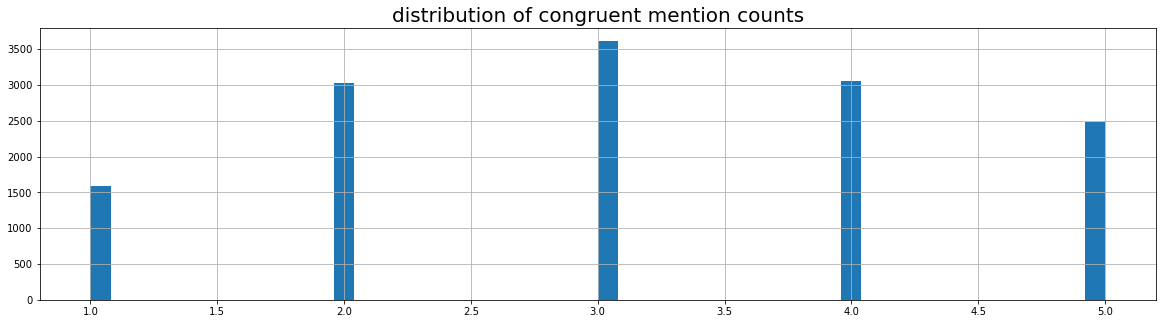

In [43]:
# What is the distribution of congruent mention counts
plt.figure(figsize=(20,5))
predictions['congruent_mentions'].apply(len).hist(bins=50)
plt.title("distribution of congruent mention counts", size=20)
plt.show()

Next, let's get a sense for the average ranking of the right answer.

In [44]:
# Prepare tracking metrics
correct_answer_rank = []
correct_answer_likelihood = {0:[],1:[],2:[],3:[],4:[]}
correct_answer_not_present = 0

# Iterate over whole dataframe
for i in tqdm(range(len(predictions))):
    row = predictions.iloc[i]
    correct_answer = row['wikipedia_page_ID']
    try:
        correct_rank = row['candidate_pool_page_ids'].index(correct_answer)
        correct_answer_rank.append(correct_rank)
        correct_answer_likelihood[correct_rank].append(row['candidate_pool_likelihoods'][correct_rank])
    except ValueError:
        correct_answer_not_present += 1

print(f"Correct answer not present {round(correct_answer_not_present/len(predictions)*100,1)}% of the time.")    

100%|██████████| 13781/13781 [00:01<00:00, 7119.31it/s]

Correct answer not present 35.9% of the time.


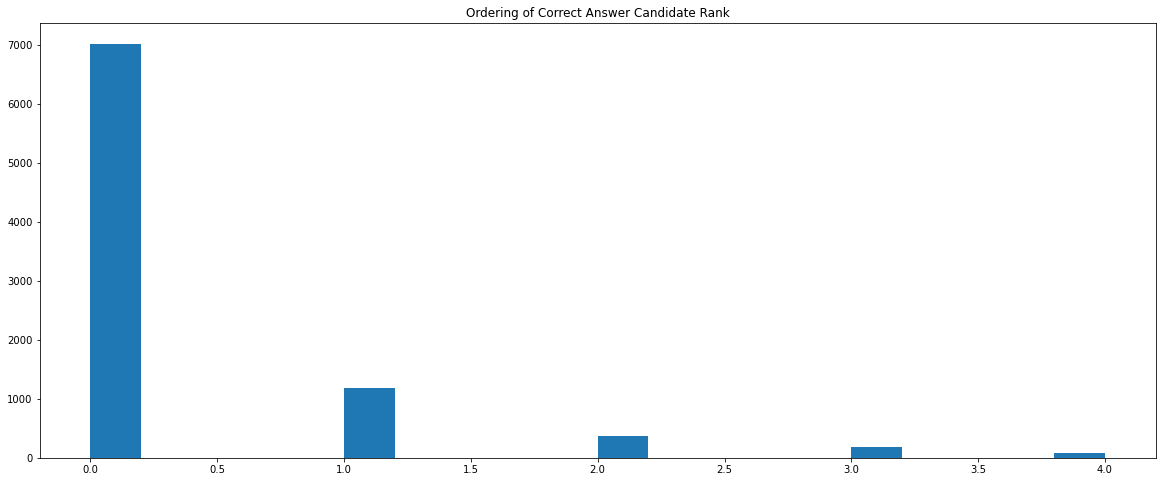

In [45]:
# Plot rank
plt.figure(figsize=(20,8))
plt.hist(correct_answer_rank, bins=20)
plt.title("Ordering of Correct Answer Candidate Rank");

In [46]:
pd.Series(correct_answer_rank).value_counts()

0    7015
1    1190
2     364
3     177
4      85
dtype: int64

In [47]:
for k,v in correct_answer_likelihood.items():
    print(f"Correct Candidate Rank: {k} - Average Prior Confidence: {round(np.mean(v),5)}")

Correct Candidate Rank: 0 - Average Prior Confidence: 0.88192
Correct Candidate Rank: 1 - Average Prior Confidence: 0.17509
Correct Candidate Rank: 2 - Average Prior Confidence: 0.07656
Correct Candidate Rank: 3 - Average Prior Confidence: 0.03768
Correct Candidate Rank: 4 - Average Prior Confidence: 0.02739


80% are in the top position, another 11% in the second place, 3% in 3rd.

### Capturing Current Design Thinking

We need to iterate through every mention's every candidate to develop the total of all sets in entity vector form. From there, we can iterate through sets to A) create the centroid vector and B) calculate each candidate distance to the centroid. With each candidate distance, we can average into a single distance congruence measure.

### Define Functions to Create Modular Congruent Pipeline

In [48]:
# Generate candidate lists of vectors
def get_candidate_pool_vectors(candidate_pool_titles, verbose=False):
    """
    Function to return entity vectors from Wikipedia2Vec
    Takes as input a list of page titles, representing the candidate pool
    Normalizes each page title to match necessary input format
    Returns entity vector or empty vector if no match
    """
    # Track failed vector queries
    no_vector_count = 0
    candidate_pool_vectors = []
    for candidate in candidate_pool_titles:
        candidate = normalize_text(candidate)
        if verbose: print(candidate)
        try:
            candidate_vectors = w2v.get_entity_vector(candidate)
        except KeyError:
            # Keep empty vector representation to maintain index locations
            candidate_vectors = np.zeros(100)
            no_vector_count += 1
        candidate_pool_vectors.append(candidate_vectors)
    
    # Handle case where candidate pool is empty from Phase 3
    # Add arbitrarily chosen 3 arrays of zeros
    if len(candidate_pool_titles) == 0:
        candidate_pool_vectors = [np.zeros(100), np.zeros(100), np.zeros(100)]
    
    if verbose: print(f"Failed Wikipedia2Vec Entity Vector Queries: {no_vector_count}")
    return candidate_pool_vectors

In [49]:
# Define function to retrieve entity vectors
def create_entity_vector_dict(sentence_mention_ids, sentence_predictions, verbose=False):
    """
    Function iterates over a provided list of congruent mentions,
    finds the associated candidate pool for each mention
    and returns the candidate pool vector
    """
    # Save vectors in dictionary
    vector_dict = {}
    
    # For each full mention we are analyzing in the contextual domain
    for m in sentence_mention_ids:
        
        # Retrieve candidate pool titles
        candidate_pool_titles = sentence_predictions['candidate_pool_titles'][m]
        if verbose: print(candidate_pool_titles)
        
        # Convert candidate pool titles to candidate pool vectors
        candidate_pool_vectors = get_candidate_pool_vectors(candidate_pool_titles, verbose=verbose)
        
        # Save candidate pool vectors to dictionary
        vector_dict[m] = candidate_pool_vectors
    
    if verbose:
        print(vector_dict.keys())
        for k in vector_dict.keys():
            print(len(vector_dict[k]))
    return vector_dict

In [50]:
# Define function to create every set of candidates across all mentions
def create_candidate_combos(vector_dict, verbose=False):
    """
    Function takes as input vector_dict, which represents candidate pool vectors for each mention
    Iterates through all candidate vectors to create single list of all combinations of candidates
    Returns that list
    """
    # Prepare list for combination
    candidate_counts = [range(len(v)) for v in vector_dict.values()]
    if verbose: print(candidate_counts)
    
    # Create product combination of all candidates
    unique_combinations = list(product(*candidate_counts))
    
    return unique_combinations

In [51]:
# Define function to calculate centroids
def calculate_centroid_candidate_dist(unique_combinations, vector_dict, verbose=False):
    """
    Function takes a list of all possible unique combinations of candidates in vector form,
    Calculates the centroid of the vectors of that combination,
    Calculates the distance of each candidate to the centroid
    Calculates the mean distance for that combination
    Returns a list of mean distance for each candidate combination to its centroid
    """
    
    # Prepare list for each combination's mean distance
    combination_distance = []
    
    # For every unique combination of candidates
    for combo in unique_combinations:
        
        # Translate combination from idx values to vectors
        combo_vector = []
        for i in range(len(combo)):
            combo_vector.append(vector_dict[i][combo[i]]) # Retrieve the vector representation

        # Calculate centroid
        centroid = sum(combo_vector)/len(combo) # Can select sum or mean by removing denominator
                
        # Calculate distance from each candidate to its combination centroid
        candidate_distances = []
        for candidate in combo_vector:
            candidate_dist = cosine_similarity(candidate.reshape(-1,1), centroid.reshape(-1,1))
            candidate_distances.append(candidate_dist)
        
        combination_distance.append(np.mean(candidate_distances))
        
    return combination_distance

#### Congruent Predictions Function

This is our main function that takes a sentence ID, calculates congruence for all candidates, updates the prior likelihood from Phase 3 with that congruence and selects predictions iteratively based on that number.

In [54]:
# Define function to calculate congruent predictions
def get_congruent_predictions(sentence_id, dataframe, verbose=False):
    """
    Function to calculate congruence metrics over a set of entity full mentions
    and return the predicted candidates based on the congruent metric
    Input:
    - Sentence ID used to filter dataframe
    - Dataframe over which to process
    Output:
    - Prediction for each entity mention
    """
    
    # Filter to dataframe representing single sentence
    # Drop duplicates necessary for sentences with the same mention included twice
    sentence_predictions = dataframe[dataframe['sentence_id'] == sentence_id]\
                        .drop_duplicates(['full_mention', 'wikipedia_URL', 'wikipedia_page_ID', 'wikipedia_title'])\
                        .reset_index(drop=True)
    if verbose: display(sentence_predictions)
    
    # Define numerical representation of congruent mention list
    sentence_congruent_mentions = sentence_predictions['congruent_mentions'][0]
    sentence_mention_ids = np.arange(len(sentence_congruent_mentions))
    if verbose:
        print("Congruent Mentions: ", sentence_congruent_mentions)
        print("Congruent Mentions as numbers: ", sentence_mention_ids)
    
    # Retrieve dictionary of candidate pool vectors for each mention
    vectors_dict = create_entity_vector_dict(sentence_mention_ids, sentence_predictions, verbose=verbose)
    if verbose: print("Mentions with Vectors: ", vectors_dict.keys())
        
    # Create full list of all unique combinations
    unique_combinations = create_candidate_combos(vectors_dict, verbose=verbose)
    # todo standardize on vector or vectors

    # Calculate average candidate distance to that combination's centroid for comparison
    combination_distance = calculate_centroid_candidate_dist(unique_combinations, vectors_dict, verbose=verbose)
    
    # Select combination with smallest distance metric, i.e. most congruent combination
    select_idx = np.argmin(combination_distance)
    most_congruent_combination = unique_combinations[select_idx]
    if verbose: print("Most Congruent Combination: ", most_congruent_combination)
    
    # Create predictions dictionary
    mention_predictions = {}
    
    # Translate combination list into dictionary
    for i in range(len(most_congruent_combination)):
        mention_predictions[i] = most_congruent_combination[i]
    if verbose: print("Numerical Predictions: ", mention_predictions)
    
    # Use mention predictions to return titles
    readable_predictions = {}
    for k, v in mention_predictions.items():
        if verbose: print(k, v)
        readable_key = sentence_congruent_mentions[k]
        try:
            readable_value = sentence_predictions['candidate_pool_titles'][k][v]
            readable_id = sentence_predictions['candidate_pool_page_ids'][k][v]
        except IndexError: # Handles case where no candidate pool was provided from Phase 3
            readable_value = None 
            readable_id = None
        except TypeError:
            # Handles case where no congruence can be calculated
            # Either due to one mention in sentence or two mentions but one with no candidate pool
            readable_value = sentence_predictions['candidate_pool_titles'][0][0] # Just return top value from Phase 3
            readable_id = sentence_predictions['candidate_pool_page_ids'][0][0]
        if verbose: print(readable_key, readable_value, readable_id)
        readable_predictions[readable_key] = (readable_value, readable_id)
    
    # Output dictionary with predictions for each entity mention based on congruence
    return readable_predictions

In [56]:
%%time
# Test out function
sentence_id = 5
congruent_predictions = get_congruent_predictions(sentence_id=sentence_id, dataframe=predictions, verbose=True)
print(congruent_predictions)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,EU,NaN,NaN,NaN,5,0,"[EU, Franz Fischler]",eu,"[9317, 9239, 21347120, 9477, 1882861]","[458, 46, 211593, 1396, 363404]","[European_Union, Europe, Eu,_Seine-Maritime, E...","[0.9227799000000001, 0.024651, 0.0201960000000..."
1,B,Franz Fischler,http://en.wikipedia.org/wiki/Franz_Fischler,626779.0,Franz Fischler,5,0,"[EU, Franz Fischler]",franz fischler,[626779],[78587],[Franz_Fischler],[1.0]


Congruent Mentions:  ['EU', 'Franz Fischler']
Congruent Mentions as numbers:  [0 1]
['European_Union', 'Europe', 'Eu,_Seine-Maritime', 'Europium', 'Citizenship_of_the_European_Union']
European Union
Europe
Eu, Seine-Maritime
Europium
Citizenship of the European Union
Failed Wikipedia2Vec Entity Vector Queries: 0
['Franz_Fischler']
Franz Fischler
Failed Wikipedia2Vec Entity Vector Queries: 0
dict_keys([0, 1])
5
1
Mentions with Vectors:  dict_keys([0, 1])
[range(0, 5), range(0, 1)]
Most Congruent Combination:  (4, 0)
Numerical Predictions:  {0: 4, 1: 0}
0 4
EU Citizenship_of_the_European_Union 1882861
1 0
Franz Fischler Franz_Fischler 626779
{'EU': ('Citizenship_of_the_European_Union', 1882861), 'Franz Fischler': ('Franz_Fischler', 626779)}
CPU times: user 24.2 ms, sys: 5.29 ms, total: 29.5 ms
Wall time: 35.1 ms


In [57]:
# Define testing sentence_id
sentence_predictions = predictions[predictions['sentence_id'] == sentence_id].reset_index(drop=True)
sentence_predictions

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,EU,NaN,NaN,NaN,5,0,"[EU, Franz Fischler]",eu,"[9317, 9239, 21347120, 9477, 1882861]","[458, 46, 211593, 1396, 363404]","[European_Union, Europe, Eu,_Seine-Maritime, E...","[0.9227799000000001, 0.024651, 0.0201960000000..."
1,B,Franz Fischler,http://en.wikipedia.org/wiki/Franz_Fischler,626779.0,Franz Fischler,5,0,"[EU, Franz Fischler]",franz fischler,[626779],[78587],[Franz_Fischler],[1.0]
2,I,Franz Fischler,http://en.wikipedia.org/wiki/Franz_Fischler,626779.0,Franz Fischler,5,0,"[EU, Franz Fischler]",franz fischler,[626779],[78587],[Franz_Fischler],[1.0]


In [58]:
print(sentence_predictions['congruent_mentions'][0])

['EU', 'Franz Fischler']


In [59]:
accuracy = 0
for mention, pred in congruent_predictions.items():
    pred_title = normalize_text(pred[0])
    true_title = sentence_predictions[sentence_predictions['full_mention'] == mention]['wikipedia_title'].values[0]
    print(mention, "->", true_title, "=?", pred_title)
    if sentence_predictions[sentence_predictions['full_mention'] == mention]['wikipedia_title'].values[0] == pred_title:
        accuracy += 1
print("*************************************************")
print(f"This congruent experiment is {round(accuracy/len(congruent_predictions)*100,3)}% accurate comparing page titles.")

EU -> nan =? Citizenship of the European Union
Franz Fischler -> Franz Fischler =? Franz Fischler
*************************************************
This congruent experiment is 50.0% accurate comparing page titles.


In [60]:
accuracy = 0
for mention, pred in congruent_predictions.items():
    pred_page_id = pred[1]
    try:
        true_page_id = int(sentence_predictions[sentence_predictions['full_mention'] == mention]['wikipedia_page_ID'].values[0])
    except ValueError:
        true_page_id = None
    print(mention, "->", true_page_id, "=?", pred_page_id)
    if sentence_predictions[sentence_predictions['full_mention'] == mention]['wikipedia_page_ID'].values[0] == pred_page_id:
        accuracy += 1
print("*************************************************")
print(f"This congruent experiment is {round(accuracy/len(congruent_predictions)*100,3)}% accurate comparing page IDs.")

EU -> None =? 1882861
Franz Fischler -> 626779 =? 626779
*************************************************
This congruent experiment is 50.0% accurate comparing page IDs.


### Calculate Congruence Predictions and Assess Accuracy over Entire Dataframe

We now apply the per-sentence structure over the whole ACY dataframe.

In [61]:
# Max sentence_id in dataframe
max_sentence_id = len(predictions['sentence_id'].unique())
print("We have {:,} sentences to predict.".format(max_sentence_id))

We have 3,935 sentences to predict.


In [62]:
# Iterate over whole dataframe to produce mention predictions for each sentence
dataframe_predictions = {}
for sid in tqdm(predictions['sentence_id'].unique()):
    dataframe_predictions[sid] = get_congruent_predictions(sid, dataframe=predictions, verbose=False)

100%|██████████| 3935/3935 [09:59<00:00,  6.56it/s] 


In [63]:
# Iterate over whole dataframe to calculate accuracy
accurate_predictions_title = 0
accurate_predictions_id = 0
for row in tqdm(range(len(predictions))):
    mention_df = predictions.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    pred = dataframe_predictions[sid][fm]
    norm_pred_title = normalize_text(pred[0])
    pred_page_id = pred[1]
#     print(fm, sid, "||| True:", title, "==? Pred:", norm_pred_title, "|||", norm_pred_title==title,\
#                  "||| True ID: ", page_id, "==? Pred:", pred_page_id, "|||", pred_page_id==page_id)
    if title == norm_pred_title:
        accurate_predictions_title += 1
    if page_id == pred_page_id:
        accurate_predictions_id += 1
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/len(predictions)*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/len(predictions)*100, 3)))

100%|██████████| 13781/13781 [00:02<00:00, 5818.89it/s]

After congruence, we have achieved 25.158% accuracy comparing title.
After congruence, we have achieved 27.081% accuracy comparing page ID.


In [64]:
# Iterate over subset of dataframe to calculate accuracy and study output results
accurate_predictions_title = 0
accurate_predictions_id = 0
rand_idx = np.random.randint(len(predictions)) # Observe random subsection of predictions
window_size = 10
for row in range(rand_idx, rand_idx+window_size):
    mention_df = predictions.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    pred = dataframe_predictions[sid][fm]
    norm_pred_title = normalize_text(pred[0])
    pred_page_id = pred[1]
    print(fm, sid, "||| True:", title, page_id, "==? Pred:", norm_pred_title, pred_page_id, "|||",\
          norm_pred_title==title, pred_page_id==page_id, " ||| Present? ", (page_id in candidate_pool_page_ids))
    if title == norm_pred_title:
        accurate_predictions_title += 1
    if page_id == pred_page_id:
        accurate_predictions_id += 1
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/window_size*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/window_size*100, 3)))

NameError: name 'candidate_pool_page_ids' is not defined

#### Calculate Accuracy only with Full Mentions with Known True

This is a better reflection of our success.

In [65]:
# Calculate length of input with known true values
known_true = sum(predictions['wikipedia_page_ID'].notnull())
print(known_true)

9785


In [66]:
# Iterate over whole dataframe to calculate accuracy
accurate_predictions_title = 0
accurate_predictions_id = 0
present_predictions_id = 0
for row in tqdm(range(len(predictions))):
    mention_df = predictions.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    candidate_pool_page_ids = mention_df['candidate_pool_page_ids']
    if page_id is None:
        pass
    elif isinstance(title, float):
        pass
    else:
        pred = dataframe_predictions[sid][fm]
        norm_pred_title = normalize_text(pred[0])
        pred_page_id = pred[1]
#         print(fm, sid, "||| True:", title, page_id, "==? Pred:", norm_pred_title, pred_page_id, "|||",\
#               norm_pred_title==title, pred_page_id==page_id, " ||| Present? ", (page_id in candidate_pool_page_ids))
        if title == norm_pred_title:
            accurate_predictions_title += 1
        if page_id == pred_page_id:
            accurate_predictions_id += 1
        if page_id in candidate_pool_page_ids:
            present_predictions_id += 1
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/known_true*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/known_true*100, 3)))
print("The right answer was present in {}% of candidate pools.".format(round(present_predictions_id/known_true*100, 3)))

100%|██████████| 13781/13781 [00:01<00:00, 6949.26it/s]

After congruence, we have achieved 35.432% accuracy comparing title.
After congruence, we have achieved 38.14% accuracy comparing page ID.
The right answer was present in 90.25% of candidate pools.


In [68]:
# Iterate over subset of dataframe to calculate accuracy and study output results
accurate_predictions_title = 0
accurate_predictions_id = 0
present_predictions_id = 0
predictions_count = 0

# Generate random window
rand_idx = np.random.randint(len(predictions)) # Observe random subsection of predictions
window_size = 10

# Pick random sentence
rand_sid = np.random.choice(predictions['sentence_id'])
rand_sentence_df = predictions[predictions['sentence_id'] == rand_sid]
print(rand_sid, len(rand_sentence_df))

for row in range(len(rand_sentence_df)):
    mention_df = rand_sentence_df.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    candidate_pool_page_ids = mention_df['candidate_pool_page_ids']
    if page_id is None: # This handles calculating over only known true
        pass
    elif isinstance(title, float): # Another way to handle only known true
        pass
    else:
        predictions_count += 1
        pred = dataframe_predictions[sid][fm]
        norm_pred_title = normalize_text(pred[0])
        pred_page_id = pred[1]
        print(fm, sid, "||| True:", title, page_id, "==? Pred:", norm_pred_title, pred_page_id, "|||",\
              norm_pred_title==title, pred_page_id==page_id, " ||| Present? ", (page_id in candidate_pool_page_ids))
        if title == norm_pred_title:
            accurate_predictions_title += 1
        if page_id == pred_page_id:
            accurate_predictions_id += 1
        if page_id in candidate_pool_page_ids:
            present_predictions_id += 1
print("***************************************")
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/predictions_count*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/predictions_count*100, 3)))
print("The right answer was present in {}% of candidate pools.".format(round(present_predictions_id/predictions_count*100, 0)))

2260 12
Los Angeles 2260 ||| True: Los Angeles 18110.0 ==? Pred: Los Angeles County, California 79734 ||| False False  ||| Present?  True
Los Angeles 2260 ||| True: Los Angeles 18110.0 ==? Pred: Los Angeles County, California 79734 ||| False False  ||| Present?  True
Greg Gagne 2260 ||| True: Greg Gagne (baseball) 4516364.0 ==? Pred: Greg Gagne (wrestler) 1983742 ||| False False  ||| Present?  True
Greg Gagne 2260 ||| True: Greg Gagne (baseball) 4516364.0 ==? Pred: Greg Gagne (wrestler) 1983742 ||| False False  ||| Present?  True
Chad Curtis 2260 ||| True: Chad Curtis 1821553.0 ==? Pred: Chad Curtis 1821553 ||| True True  ||| Present?  True
Chad Curtis 2260 ||| True: Chad Curtis 1821553.0 ==? Pred: Chad Curtis 1821553 ||| True True  ||| Present?  True
Los Angeles Dodgers 2260 ||| True: Los Angeles Dodgers 18213.0 ==? Pred: 1959 Los Angeles Dodgers season 12937911 ||| False False  ||| Present?  True
Los Angeles Dodgers 2260 ||| True: Los Angeles Dodgers 18213.0 ==? Pred: 1959 Los Angele

In [434]:
# See original dataframe
predictions[predictions['sentence_id'] == rand_sid]

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
12038,B,Sao Paulo,http://en.wikipedia.org/wiki/São_Paulo_(state),229422.0,São Paulo (state),2879,471,"[Sao Paulo, Mario Covas, Banespa, O Globo]",sao paulo,"[390875, 229422, 187274]","[174, 175, 38568]","[São_Paulo, São_Paulo_(state), São_Paulo_FC]","[0.9563318999999999, 0.0334789, 0.0101892]"
12039,I,Sao Paulo,http://en.wikipedia.org/wiki/São_Paulo_(state),229422.0,São Paulo (state),2879,471,"[Sao Paulo, Mario Covas, Banespa, O Globo]",sao paulo,"[390875, 229422, 187274]","[174, 175, 38568]","[São_Paulo, São_Paulo_(state), São_Paulo_FC]","[0.9563318999999999, 0.0334789, 0.0101892]"
12040,B,Mario Covas,http://en.wikipedia.org/wiki/Mário_Covas,3386439.0,Mário Covas,2879,471,"[Sao Paulo, Mario Covas, Banespa, O Globo]",mario covas,[3386439],[1669473],[Mário_Covas],[1.0]
12041,I,Mario Covas,http://en.wikipedia.org/wiki/Mário_Covas,3386439.0,Mário Covas,2879,471,"[Sao Paulo, Mario Covas, Banespa, O Globo]",mario covas,[3386439],[1669473],[Mário_Covas],[1.0]
12042,B,Sao Paulo,http://en.wikipedia.org/wiki/São_Paulo_(state),229422.0,São Paulo (state),2879,471,"[Sao Paulo, Mario Covas, Banespa, O Globo]",sao paulo,"[390875, 229422, 187274]","[174, 175, 38568]","[São_Paulo, São_Paulo_(state), São_Paulo_FC]","[0.9563318999999999, 0.0334789, 0.0101892]"
12043,I,Sao Paulo,http://en.wikipedia.org/wiki/São_Paulo_(state),229422.0,São Paulo (state),2879,471,"[Sao Paulo, Mario Covas, Banespa, O Globo]",sao paulo,"[390875, 229422, 187274]","[174, 175, 38568]","[São_Paulo, São_Paulo_(state), São_Paulo_FC]","[0.9563318999999999, 0.0334789, 0.0101892]"
12044,B,Banespa,NaN,NaN,NaN,2879,471,"[Sao Paulo, Mario Covas, Banespa, O Globo]",banespa,"[32820442, 3752752]","[4854074, 169420]","[Banco_Banespa, Altino_Arantes_Building]","[0.8571429, 0.14285710000000001]"
12045,B,O Globo,http://en.wikipedia.org/wiki/O_Globo,2093729.0,O Globo,2879,471,"[Sao Paulo, Mario Covas, Banespa, O Globo]",o globo,[2093729],[970729],[O_Globo],[1.0]
12046,I,O Globo,http://en.wikipedia.org/wiki/O_Globo,2093729.0,O Globo,2879,471,"[Sao Paulo, Mario Covas, Banespa, O Globo]",o globo,[2093729],[970729],[O_Globo],[1.0]


In [435]:
# See full candidate pool
predictions[predictions['sentence_id'] == rand_sid]['candidate_pool_titles'].iloc[1]

['São_Paulo', 'São_Paulo_(state)', 'São_Paulo_FC']

### Calculate with *Popularity* Predictions Known True Only

In [316]:
# Load data
predictions_pop = pd.read_csv(os.path.join(preds_path, "anchortext_popularity.csv"), delimiter=",")
predictions_pop.head(5)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",eu,"[9317, 9239, 9891, 9472, 10890716, 2780146, 18...","[458, 46, 45003, 4916, 185441, 932442, 8268, 8...","['European_Union', 'Europe', 'Entropy', 'Euro'...","[0.2237612, 0.2008411, 0.0962244, 0.0766248, 0..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",german,"[11867, 11867, 27318, 21148, 21212, 21212, 269...","[183, 183, 334, 55, 7318, 7318, 40, 12548, 825...","['Germany', 'Germany', 'Singapore', 'Netherlan...","[0.0494115, 0.0494115, 0.0485629, 0.0390487, 0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",british,"[3434750, 31717, 31717, 19344654, 26061, 85699...","[30, 145, 145, 9531, 172771, 1860, 21, 22, 868...","['United_States', 'United_Kingdom', 'United_Ki...","[0.115186, 0.0611816, 0.0611816, 0.0294143, 0...."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 56873217, 9643132]","[2073954, 26634508, 7172840]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.6296296, 0.3703704, 0.0]"
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 56873217, 9643132]","[2073954, 26634508, 7172840]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.6296296, 0.3703704, 0.0]"


In [343]:
%%time

### Apply defined function to entire dataframe for all candidate pool columns

column = 'congruent_mentions'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=str)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])

column = 'candidate_pool_page_ids'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=int)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])


column = 'candidate_pool_item_ids'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=int)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])


column = 'candidate_pool_titles'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=str)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])

column = 'candidate_pool_likelihoods'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=float)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])

Before ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
After ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
Before [56783206, 56873217, 9643132]
After [56783206, 56873217, 9643132]
Before [2073954, 26634508, 7172840]
After [2073954, 26634508, 7172840]
Before ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(MP)', 'Peter_Blackburn_(bishop)']
After ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(MP)', 'Peter_Blackburn_(bishop)']
Before [0.6296296, 0.3703704, 0.0]
After [0.6296296, 0.3703704, 0.0]
CPU times: user 683 ms, sys: 306 ms, total: 990 ms
Wall time: 1 s


In [344]:
# Calculate length of input with known true values
known_true = sum(predictions_pop['wikipedia_page_ID'].notnull())
print(known_true)

22257


In [345]:
%%time
# Test out function
congruent_predictions = get_congruent_predictions(sentence_id=0, dataframe=predictions_pop, verbose=True)
print(congruent_predictions)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,EU,NaN,NaN,NaN,0,0,"[EU, German, British]",eu,"[9317, 9239, 9891, 9472, 10890716, 2780146, 18...","[458, 46, 45003, 4916, 185441, 932442, 8268, 8...","[European_Union, Europe, Entropy, Euro, Member...","[0.2237612, 0.2008411, 0.0962244, 0.0766248, 0..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"[EU, German, British]",german,"[11867, 11867, 27318, 21148, 21212, 21212, 269...","[183, 183, 334, 55, 7318, 7318, 40, 12548, 825...","[Germany, Germany, Singapore, Netherlands, Naz...","[0.0494115, 0.0494115, 0.0485629, 0.0390487, 0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"[EU, German, British]",british,"[3434750, 31717, 31717, 19344654, 26061, 85699...","[30, 145, 145, 9531, 172771, 1860, 21, 22, 868...","[United_States, United_Kingdom, United_Kingdom...","[0.115186, 0.0611816, 0.0611816, 0.0294143, 0...."


Congruent Mentions:  ['EU', 'German', 'British']
Congruent Mentions as numbers:  [0 1 2]
['European_Union', 'Europe', 'Entropy', 'Euro', 'Member_state_of_the_European_Union', 'European_emission_standards', 'Eurozone', 'European_Parliament', 'European_Commission', 'Europe,_the_Middle_East_and_Africa']
Failed Wikipedia2Vec Entity Vector Queries: 0
['Germany', 'Germany', 'Singapore', 'Netherlands', 'Nazi_Germany', 'Nazi_Germany', 'Austria', 'Holy_Roman_Empire', 'Bundesliga', 'Age_of_Enlightenment']
Failed Wikipedia2Vec Entity Vector Queries: 0
['United_States', 'United_Kingdom', 'United_Kingdom', 'BBC', 'Royal_Navy', 'English_language', 'England', 'Scotland', 'British_Empire', 'Commonwealth_of_Nations']
Failed Wikipedia2Vec Entity Vector Queries: 0
dict_keys([0, 1, 2])
10
10
10
Mentions with Vectors:  dict_keys([0, 1, 2])
Comparing mentions 0 & 1
Comparing mentions 0 & 2
Comparing mentions 1 & 2
First-Level Congruence Keys:  dict_keys([0, 1])
Comparing mentions 0 & 1
Comparing mentions 0 

In [346]:
# Iterate over whole dataframe to produce mention predictions for each sentence
dataframe_predictions_pop = {}
for sid in tqdm(predictions_pop['sentence_id'].unique()):
    dataframe_predictions_pop[sid] = get_congruent_predictions(sid, dataframe=predictions_pop, verbose=False)

100%|██████████| 4516/4516 [02:34<00:00, 29.14it/s] 


In [347]:
# Iterate over whole dataframe to calculate accuracy
accurate_predictions_title = 0
accurate_predictions_id = 0
for row in tqdm(range(len(predictions_pop))):
    mention_df = predictions_pop.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    if page_id is None:
        pass
    else:
        pred = dataframe_predictions_pop[sid][fm]
        norm_pred_title = normalize_text(pred[0])
        pred_page_id = pred[1]
    #     print(fm, sid, "||| True:", title, "==? Pred:", norm_pred_title, "|||", norm_pred_title==title,\
    #                  "||| True ID: ", page_id, "==? Pred:", pred_page_id, "|||", pred_page_id==page_id)
        if title == norm_pred_title:
            accurate_predictions_title += 1
        if page_id == pred_page_id:
            accurate_predictions_id += 1
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/known_true*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/known_true*100, 3)))

100%|██████████| 29312/29312 [00:03<00:00, 7468.39it/s]

After congruence, we have achieved 57.959% accuracy comparing title.
After congruence, we have achieved 62.066% accuracy comparing page ID.


# Logical Flow Demonstration

The cells below have been included as a more easily understood logical flow to understand how we designed the recursive congruence algorithm for an arbitrary length of full mentions in a sentence. We manually select a sentence and work through that. This is identical to the above but with more printed out breaks.

#### Known Oddities
1. Test with sentence_id == 1. We only return unique mentions in a single sentence. Is that ok?

In [21]:
# Test on manually selected sentence
sentence_predictions = predictions[predictions['sentence_id'] == 1].drop_duplicates(['full_mention', 'wikipedia_page_ID', 'sentence_id']).reset_index(drop=True)
sentence_predictions

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,Peter Blackburn,NaN,NaN,NaN,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","[Peter_Blackburn_(badminton), Peter_Blackburn_...","[0.5, 0.3, 0.2]"
1,B,BRUSSELS,http://en.wikipedia.org/wiki/Brussels,3708.0,Brussels,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",brussels,"[3708, 575501, 1437181, 269753, 4152470]","[240, 239, 1050331, 28934, 800587]","[Brussels, City_of_Brussels, R.W.D.M._Brussels...","[0.9631528, 0.011514700000000001, 0.0037143999..."
2,B,European Commission,http://en.wikipedia.org/wiki/European_Commission,9974.0,European Commission,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",european commission,"[9974, 24468, 1130631, 1549462, 656283]","[8880, 8882, 388354, 1780232, 2661677]","[European_Commission, President_of_the_Europea...","[0.9959089, 0.0008894, 0.0005336000000000001, ..."
3,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",german,"[11867, 11884, 152735, 21212, 12674]","[183, 188, 42884, 7318, 43287]","[Germany, German_language, Germans, Nazi_Germa...","[0.4192066, 0.2893363, 0.1470461, 0.03832, 0.0..."
4,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",british,"[31717, 19097669, 13530298, 4721, 158019]","[145, 842438, 23666, 8680, 161885]","[United_Kingdom, British_people, Great_Britain...","[0.6101255999999999, 0.1146913, 0.0681775, 0.0..."


In [22]:
# Congruent Mention
print(sentence_predictions['congruent_mentions'][0])

['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']


In [23]:
# Convert to numerical for easier recursive logic later
sentence_mention_nums = np.arange(len(sentence_predictions['congruent_mentions'][0]))
sentence_mention_nums

array([0, 1, 2, 3, 4])

In [24]:
# Generate candidate lists of vectors
def get_candidate_pool_vectors(candidate_pool_titles, verbose=False):
    """
    Function to return entity vectors from Wikipedia2Vec
    Takes as input a list of page titles, representing the candidate pool
    Normalizes each page title to match necessary input format
    Returns entity vector or empty vector if no match
    """
    # Track failed vector queries
    no_vector_count = 0
    candidate_pool_vectors = []
    for candidate in candidate_pool_titles:
        candidate = normalize_text(candidate)
        try:
            candidate_vectors = w2v.get_entity_vector(candidate)
        except KeyError:
            # Keep empty vector representation to maintain index locations
            candidate_vectors = np.zeros(100)
            no_vector_count += 1
        candidate_pool_vectors.append(candidate_vectors)
    
    if len(candidate_pool_titles) == 0:
        candidate_pool_vectors = [np.zeros(100), np.zeros(100), np.zeros(100)]
    
    if verbose: print(f"Failed Wikipedia2Vec Entity Vector Queries: {no_vector_count}")
    return candidate_pool_vectors

In [25]:
# Save vectors in dictionary
vector_dict = {}

# For each full mention we are analyzing in the contextual domain (i.e. sentence)
for m in sentence_mention_nums:
    
    # Retrieve candidate pool titles
    candidate_pool_titles = sentence_predictions['candidate_pool_titles'][m]
    
    # Convert candidate pool titles to candidate pool vectors
    candidate_pool_vectors = get_candidate_pool_vectors(candidate_pool_titles, verbose=True)
    
    # Save candidate pool vectors to dictionary
    vector_dict[m] = candidate_pool_vectors
    

Failed Wikipedia2Vec Entity Vector Queries: 2
Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 0


In [26]:
# Display vector_dict output
print(vector_dict.keys())
# Preview one candidate vector from a candidate pool vectors
vector_dict[1]

dict_keys([0, 1, 2, 3, 4])


[memmap([ 0.73999596, -0.2850568 ,  0.88725674, -0.50734735, -0.6356713 ,
         -0.20261607,  0.01270186, -0.43192133,  0.17652708, -1.2671794 ,
          0.25022364, -0.8501609 ,  1.1788144 , -0.9606329 ,  0.2951649 ,
          0.28013518,  0.4906645 , -0.04022525,  0.30440256, -0.7108611 ,
         -1.0442777 ,  0.23103824, -0.16828535, -0.4928129 , -0.5990831 ,
          0.65428317,  0.55305684,  0.09535707,  0.41192013, -0.5112566 ,
         -0.03250094, -0.26022622,  0.9529309 ,  0.00581418, -0.40577435,
          0.54995644,  0.8707861 ,  0.8141234 ,  0.25183964, -1.4443197 ,
         -0.88571143,  0.09944484, -0.5551198 ,  0.951958  , -0.5003791 ,
         -0.3015914 , -0.2980206 ,  0.14974946, -0.64372563, -0.63113153,
          1.1873055 ,  0.03172509, -0.2136898 , -1.1639937 ,  0.24281068,
          0.3994873 ,  0.23474444,  0.60516006, -1.0773419 ,  0.8272827 ,
          1.0121135 , -0.5333727 , -0.9532066 ,  0.67113334,  0.62456834,
         -0.5706873 , -0.11329702,  1.

In [27]:
# Structure logic to create all combinations of candidates
candidate_counts = [range(len(v)) for v in vector_dict.values()]
candidate_counts

[range(0, 3), range(0, 5), range(0, 5), range(0, 5), range(0, 5)]

In [28]:
from itertools import product

In [34]:
unique_combinations_idx = list(product(*candidate_counts))
unique_combinations_idx[:10]

[(0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1),
 (0, 0, 0, 0, 2),
 (0, 0, 0, 0, 3),
 (0, 0, 0, 0, 4),
 (0, 0, 0, 1, 0),
 (0, 0, 0, 1, 1),
 (0, 0, 0, 1, 2),
 (0, 0, 0, 1, 3),
 (0, 0, 0, 1, 4)]

In [35]:
## Translate unique combination indexes into list of vector combinations
unique_combinations = []
for combo in unique_combinations_idx:
#     print(combo)
    combo_vector = []
    for i in range(len(combo)):
        combo_vector.append(vector_dict[i][combo[i]])
    unique_combinations.append(combo_vector)

In [36]:
# Calculate centroids for each unique combination
centroids = []
for combo in unique_combinations:
    centroids.append(sum(combo)) #/len(combo)) if you want mean

In [37]:
# Each position should now have one
centroids[0]              # Leave as is for sum of vectors
# np.array(centroids[0])/5  # Divide by mention count for mean of vectors

array([ 2.131043  , -0.03438118,  2.4980736 , -0.7308637 , -1.1257738 ,
       -0.49353868,  1.0083045 , -1.0838606 ,  0.75853443, -5.91596   ,
        0.47778386, -1.3803507 ,  2.8838859 , -5.77764   , -1.5809379 ,
       -0.7298596 ,  2.0230465 , -0.5698778 ,  1.3996718 , -0.73016936,
       -1.5379165 ,  2.231394  , -1.0941744 , -1.3733233 , -2.2880337 ,
        1.8583322 ,  2.8878713 , -1.3950173 ,  0.5865395 ,  0.8182961 ,
       -0.37736836, -0.1751889 ,  3.4341693 ,  2.48418   ,  1.6804861 ,
        0.1854988 ,  1.6437321 ,  1.0341145 ,  0.44050485, -1.1708148 ,
        0.7957667 , -1.3546429 ,  0.38562632,  3.6486506 , -0.76347744,
       -1.1840131 , -0.9945575 ,  3.122835  , -2.0672047 , -2.3407288 ,
        2.0564058 ,  1.6348517 ,  1.4340049 , -2.695025  ,  0.19447258,
        0.7308686 ,  2.818136  ,  1.1672243 , -2.6244626 ,  1.1208712 ,
        2.4334676 ,  0.36272705, -1.8655688 ,  1.482802  ,  5.2873936 ,
       -1.9874624 , -2.7909927 ,  1.2789898 , -2.3831098 , -3.96

In [38]:
# Confirm we have a centroid for every set
assert len(unique_combinations) == len(centroids)

In [39]:
from sklearn.metrics import pairwise

In [157]:
# Calculate cosine similarity as distance between each candidate and that set's centroid
set_distances = []
for i in range(len(unique_combinations)):
    candidate_distances = []
    combination = unique_combinations[i]
    centroid = centroids[i]
    for candidate in combination:
        
        # todo which should I be using?
        candidate_distance = cosine_similarity(candidate.reshape(-1, 1), centroid.reshape(-1, 1))
#         candidate_distance = pairwise.pairwise_distances(candidate.reshape(-1, 1), centroid.reshape(-1, 1), metric='cosine')

        candidate_distances.append(candidate_distance)
    set_distances.append(candidate_distances)

In [158]:
set_distances[0] # Example combination

[array([[-1.,  1., -1., ..., -1.,  1.,  1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        ...,
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [ 1., -1.,  1., ...,  1., -1., -1.]], dtype=float32),
 array([[ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        ...,
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.]], dtype=float32),
 array([[ 1., -1.,  1., ...,  1., -1., -1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        ...,
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.]], dtype=float32),
 array([[ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [ 

In [159]:
set_distances[0][0] # Example candidate

array([[-1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1., -1., -1.],
       [ 1., -1.,  1., ...,  1., -1., -1.],
       ...,
       [ 1., -1.,  1., ...,  1., -1., -1.],
       [-1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1., -1., -1.]], dtype=float32)

In [160]:
average_set_distance = [np.mean(combo) for combo in set_distances]

In [161]:
max(average_set_distance), min(average_set_distance)

(0.0176, -0.00528)

In [167]:
select_idx = np.argmin(average_set_distance)
select_idx

450

In [168]:
most_congruent_predictions = unique_combinations_idx[select_idx]
most_congruent_predictions

(0, 3, 3, 0, 0)

In [169]:
# See what we got done
mention_predictions = {}
for i in range(len(most_congruent_predictions)):
    mention_predictions[i] = most_congruent_predictions[i]
mention_predictions

{0: 0, 1: 3, 2: 3, 3: 0, 4: 0}

In [170]:
sentence_predictions.columns

Index(['mention', 'full_mention', 'wikipedia_URL', 'wikipedia_page_ID',
       'wikipedia_title', 'sentence_id', 'doc_id', 'congruent_mentions',
       'norm_full_mention', 'candidate_pool_page_ids',
       'candidate_pool_item_ids', 'candidate_pool_titles',
       'candidate_pool_likelihoods'],
      dtype='object')

In [171]:
correct_predictions = 0
answer_present = 0

for i in range(len(sentence_predictions)):
    row = sentence_predictions.iloc[i]
    full_mention = row['full_mention']
    wiki_title = row['wikipedia_title']
    wiki_page_id = row['wikipedia_page_ID']
    candidate_pool_titles = row['candidate_pool_titles']
    candidate_pool_page_ids = row['candidate_pool_page_ids']
    pred_idx = mention_predictions[i]
    pred_title = candidate_pool_titles[pred_idx]
    pred_page_id = candidate_pool_page_ids[pred_idx]
    print(f"Text: {full_mention} - True: {wiki_title}, {wiki_page_id} ==? Pred: {pred_title},{pred_page_id}")
    if wiki_page_id == pred_page_id:
        correct_predictions += 1
    if wiki_page_id in candidate_pool_page_ids:
        answer_present += 1

print("*********************************************")
print(f"We predicted {round(correct_predictions/len(sentence_predictions)*100,2)}% mentions correctly.")
print(f"The correct answer was present in {round(answer_present/len(sentence_predictions)*100,2)}% candidate pools.") 

Text: Peter Blackburn - True: nan, nan ==? Pred: Peter_Blackburn_(badminton),56783206
Text: BRUSSELS - True: Brussels, 3708.0 ==? Pred: Brussels_Airport,269753
Text: European Commission - True: European Commission, 9974.0 ==? Pred: European_Commissioner_for_Competition,1549462
Text: German - True: Germany, 11867.0 ==? Pred: Germany,11867
Text: British - True: United Kingdom, 31717.0 ==? Pred: United_Kingdom,31717
*********************************************
We predicted 40.0% mentions correctly.
The correct answer was present in 80.0% candidate pools.


In [141]:
print("You've predicted everything!")

You've predicted everything!
